# Advanced usage

*fastTSNE* also supports more advanced usage. This API is useful mainly if we are interested in how the algorithm works and how different parameter settings affect the optimization process.

In [1]:
from fastTSNE import TSNE
from fastTSNE.callbacks import ErrorLogger

from examples import utils

import numpy as np
import scipy.sparse as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

### Load data

In [2]:
x, y = utils.get_zeisel_2018()

In [3]:
print('Data set contains %d samples with %d features' % x.shape)

Data set contains 160796 samples with 27932 features


### Create train/test split

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3)

Additionally, we will move all the cells from one class into the test set. Our motivation for this will be made clear later on.

In [5]:
mask = y_train == 'Immature neural'
x_test = sp.vstack((x_test, x_train[mask]))
y_test = np.hstack((y_test, y_train[mask]))
x_train = x_train[~mask]
y_train = y_train[~mask]

In [6]:
print('%d training samples' % x_train.shape[0])
print('%d test samples' % x_test.shape[0])

108757 training samples
52039 test samples


### SVD preprocessing

In [7]:
svd = TruncatedSVD(n_components=50)

In [8]:
%time x_prime_train = svd.fit_transform(x_train)

CPU times: user 1min 5s, sys: 7.83 s, total: 1min 12s
Wall time: 1min 1s


## Creating a t-SNE embedding

In [9]:
tsne = TSNE(n_components=2, negative_gradient_method='fft', neighbors='approx',
            callbacks=ErrorLogger(), n_jobs=8)

First, we have to prepare the initial embedding. This can take some times since this step precomputes the nearest neighbors and forms the affinity matrix. We do this here since these only need to be performed once and will be reused during otimization.

In [10]:
%time embedding_train = tsne.prepare_initial(x_prime_train)

CPU times: user 42.5 s, sys: 2.7 s, total: 45.2 s
Wall time: 21.7 s


The default initialization performs PCA on the input data. This is not to be confused with PCA preprocessing. This PCA takes the input data and projects it into 2D space. This projection is used as the initial t-SNE embedding, which we optimize. In practice, this usually helps t-SNE converge faster.

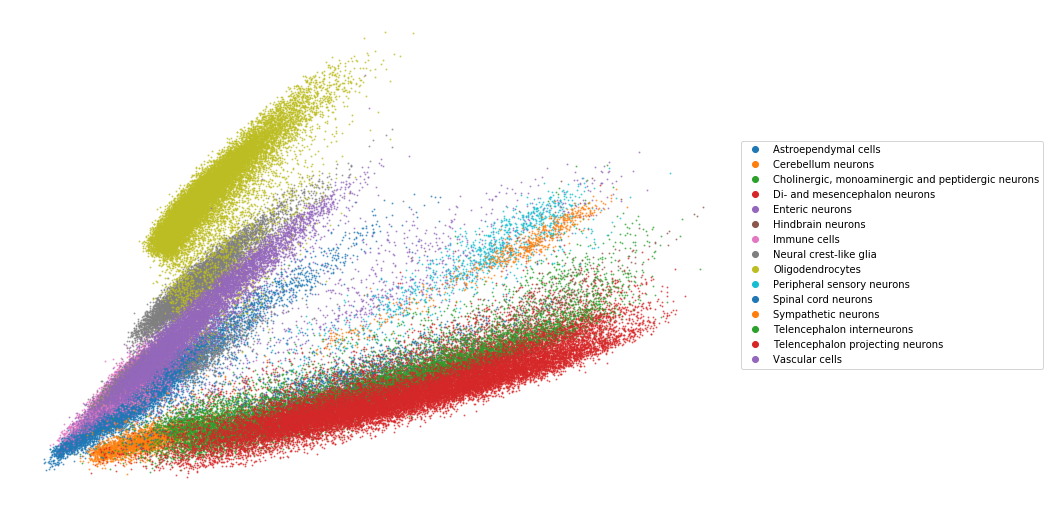

In [11]:
utils.plot(embedding_train, y_train, ax=plt.figure(figsize=(13, 9)).gca())

Now, we'll begin optimization. The first step in t-SNE is the so-called *early exaggeration* phase. It's purpose is to pull similar points together so the clusters are well separated from each other.

In [12]:
%time embedding_train = embedding_train.optimize(n_iter=250, exaggeration=12, momentum=0.5)

Iteration   50, KL divergence  7.9773, 50 iterations in 3.0878 sec
Iteration  100, KL divergence  7.1081, 50 iterations in 3.1861 sec
Iteration  150, KL divergence  6.3195, 50 iterations in 3.1321 sec
Iteration  200, KL divergence  5.8746, 50 iterations in 3.2771 sec
Iteration  250, KL divergence  5.5929, 50 iterations in 3.3488 sec
CPU times: user 1min 47s, sys: 152 ms, total: 1min 47s
Wall time: 16.2 s


In larger data sets, the default number of iterations sometimes isn't enough to produce good visualizations. We can see above that the KL divergence hasn't stabilized after 250 iterations, so we may want to continue this phase.

In [13]:
%time embedding_train = embedding_train.optimize(n_iter=500, exaggeration=12, momentum=0.5)

Iteration   50, KL divergence  5.5621, 50 iterations in 3.5899 sec
Iteration  100, KL divergence  5.4985, 50 iterations in 3.4874 sec
Iteration  150, KL divergence  5.4065, 50 iterations in 3.4607 sec
Iteration  200, KL divergence  5.3117, 50 iterations in 3.4807 sec
Iteration  250, KL divergence  5.2243, 50 iterations in 3.5174 sec
Iteration  300, KL divergence  5.1454, 50 iterations in 3.6107 sec
Iteration  350, KL divergence  5.0826, 50 iterations in 3.5216 sec
Iteration  400, KL divergence  5.0291, 50 iterations in 3.5168 sec
Iteration  450, KL divergence  4.9813, 50 iterations in 3.5151 sec
Iteration  500, KL divergence  4.9457, 50 iterations in 3.5092 sec
CPU times: user 3min 47s, sys: 521 ms, total: 3min 47s
Wall time: 35.4 s


After an additional 500 iterations of early exaggeration (so 750 iterations in total), the KL divergence seems to have somewhat stabilized. Let's examine the result.

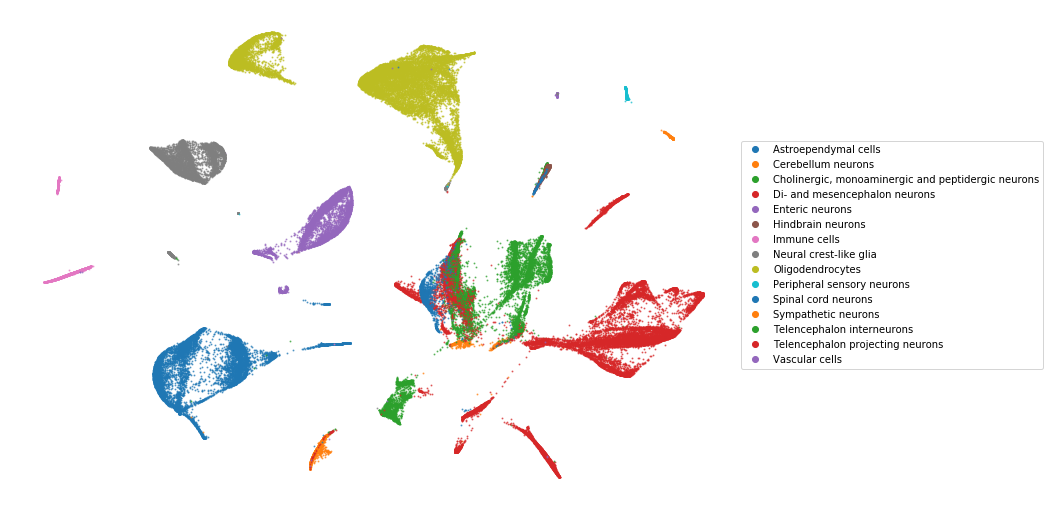

In [14]:
utils.plot(embedding_train, y_train, ax=plt.figure(figsize=(13, 9)).gca())

As we can see from the plot, during this phase, we've pulled apart some distinct clusters.

We now proceed to the normal t-SNE optimization phase. We run the procedure for 1000 iterations so the KL divergence has more time to reach a stable point. The values for momentum are set from other implementations of t-SNE and are the default for other software packages.

In [15]:
%time embedding_train = embedding_train.optimize(n_iter=1000, momentum=0.8)

Iteration   50, KL divergence  4.7579, 50 iterations in 3.8580 sec
Iteration  100, KL divergence  4.5763, 50 iterations in 3.4045 sec
Iteration  150, KL divergence  4.4482, 50 iterations in 3.8387 sec
Iteration  200, KL divergence  4.3171, 50 iterations in 3.4691 sec
Iteration  250, KL divergence  4.1810, 50 iterations in 3.4251 sec
Iteration  300, KL divergence  4.0481, 50 iterations in 3.8157 sec
Iteration  350, KL divergence  3.9234, 50 iterations in 3.8900 sec
Iteration  400, KL divergence  3.8082, 50 iterations in 3.9476 sec
Iteration  450, KL divergence  3.7029, 50 iterations in 4.0001 sec
Iteration  500, KL divergence  3.6073, 50 iterations in 4.3994 sec
Iteration  550, KL divergence  3.5199, 50 iterations in 4.6364 sec
Iteration  600, KL divergence  3.4404, 50 iterations in 4.3810 sec
Iteration  650, KL divergence  3.3681, 50 iterations in 4.4038 sec
Iteration  700, KL divergence  3.3018, 50 iterations in 5.5833 sec
Iteration  750, KL divergence  3.2410, 50 iterations in 4.6024

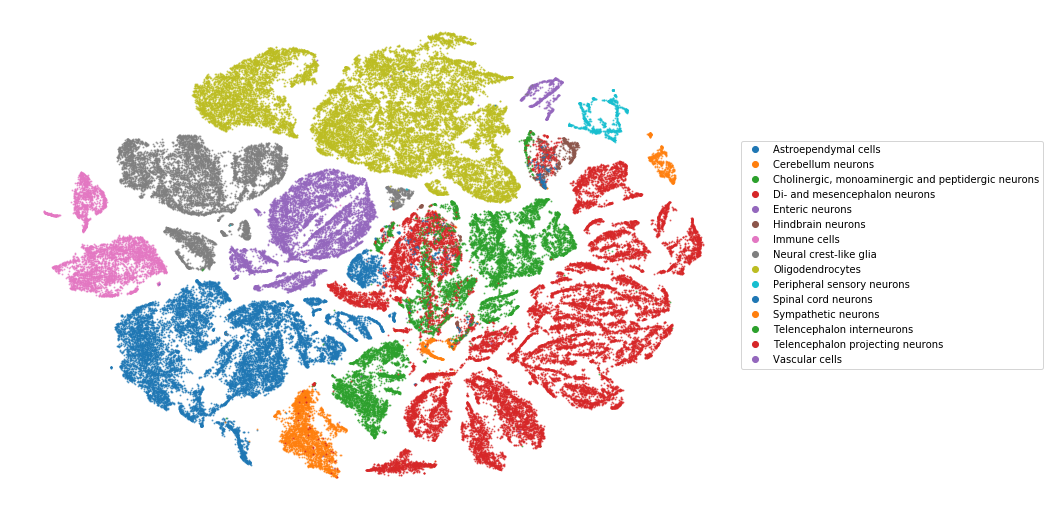

In [16]:
utils.plot(embedding_train, y_train, ax=plt.figure(figsize=(13, 9)).gca())

We've now got a similar embedding as we did in `simple_usage.ipynb`.

## Adding new samples into the embedding

We can also use this API to add new samples into the embedding, giving us more control and allowing us to understand the process better. Finding good projections can be a bit tricky and can require a bit of tuning, so this API comes in particularly handy.

In [17]:
%time x_prime_test = svd.transform(x_test)

CPU times: user 2.79 s, sys: 3.2 ms, total: 2.8 s
Wall time: 2.81 s


In [18]:
%time embedding_test = embedding_train.prepare_partial(x_prime_test)

CPU times: user 14.7 s, sys: 143 ms, total: 14.8 s
Wall time: 5.21 s


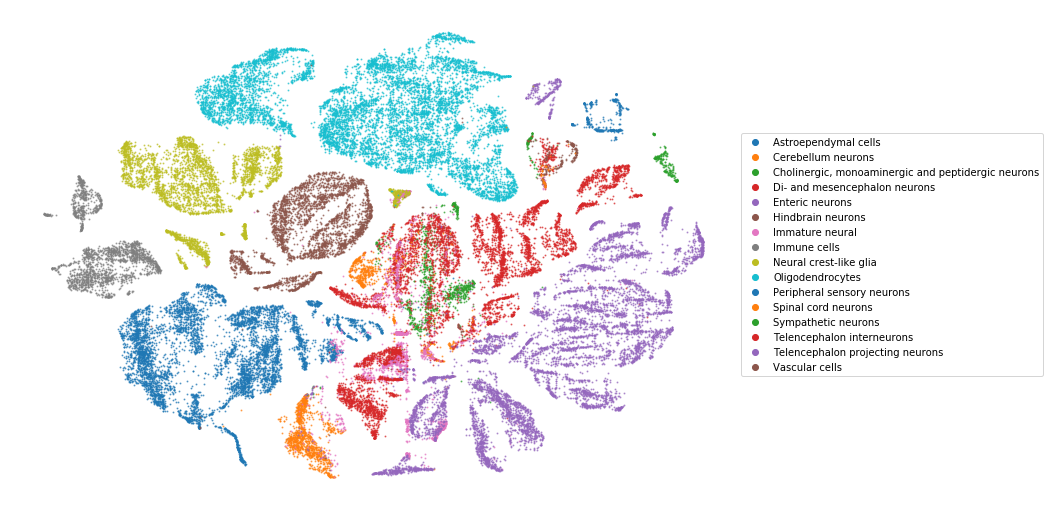

In [19]:
utils.plot(embedding_test, y_test, ax=plt.figure(figsize=(13, 9)).gca())

The initial embedding already looks very similar to what we saw above. This is because new point positions are the weighted average position of it's nearest neighbors.

Why, then, would we need to run optimization at all? Notice the pink points. These are the samples from the class that doesn't appear at all in the training set (remember we moved all of them to the test set above). They seem scattered all over the place. These points shouldn't overlap with any of the defined clusters. Optimization allows us to see that something strange is going on with these samples.

In [20]:
%time embedding_test = embedding_test.optimize(n_iter=500, exaggeration=30, momentum=0)

Iteration   50, KL divergence  3.8646, 50 iterations in 4.9575 sec
Iteration  100, KL divergence  3.7276, 50 iterations in 6.4514 sec
Iteration  150, KL divergence  3.6694, 50 iterations in 6.5550 sec
Iteration  200, KL divergence  3.6322, 50 iterations in 7.6587 sec
Iteration  250, KL divergence  3.6084, 50 iterations in 9.3831 sec
Iteration  300, KL divergence  3.5878, 50 iterations in 11.4457 sec
Iteration  350, KL divergence  3.5724, 50 iterations in 12.1649 sec
Iteration  400, KL divergence  3.5579, 50 iterations in 14.7943 sec
Iteration  450, KL divergence  3.5487, 50 iterations in 17.5267 sec
Iteration  500, KL divergence  3.5419, 50 iterations in 16.6151 sec
CPU times: user 3min 17s, sys: 4.2 s, total: 3min 22s
Wall time: 1min 48s


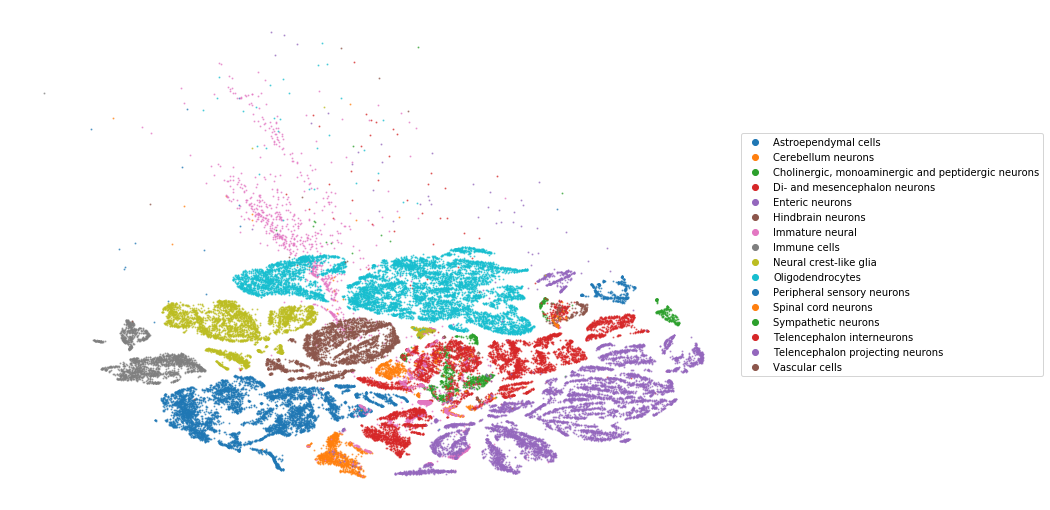

In [21]:
utils.plot(embedding_test, y_test, ax=plt.figure(figsize=(13, 9)).gca())

The exaggeration phase here is especially important because it allows the pink points to "escape" from the center of the embedding. Larger exaggeration values also seem help with this. From the embedding, it is apparent that something strange is happening with the pink points, and requires further inspection.

In [22]:
%time embedding_test = embedding_test.optimize(n_iter=250)

Iteration   50, KL divergence  3.5296, 50 iterations in 28.9428 sec
Iteration  100, KL divergence  3.5251, 50 iterations in 14.9459 sec
Iteration  150, KL divergence  3.5213, 50 iterations in 16.9292 sec
Iteration  200, KL divergence  3.5191, 50 iterations in 19.3273 sec
Iteration  250, KL divergence  3.5175, 50 iterations in 23.0732 sec
CPU times: user 2min 26s, sys: 6.84 s, total: 2min 33s
Wall time: 1min 43s


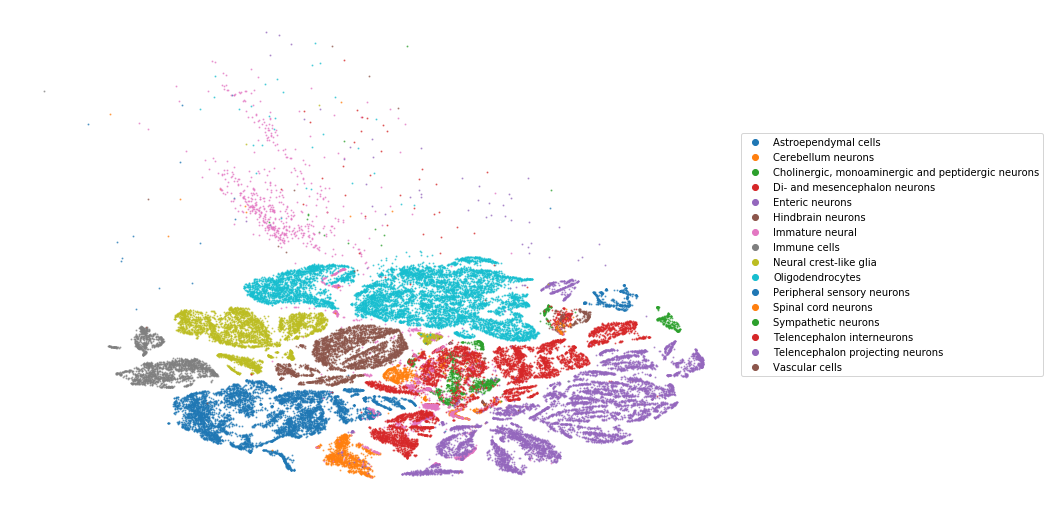

In [23]:
utils.plot(embedding_test, y_test, ax=plt.figure(figsize=(13, 9)).gca())

It's a good idea to run optimization without exaggeration to allow the other points to settle into proper positions.

Notice that the other points haven't really moved at all. If we expect that new samples come from the same distribution i.e. we don't expect any new classes, then optimization can be run for much fewer steps and exaggeration isn't necessary.

Lastly, we'll overlay the test set over the training set. The colors don't match up exactly because the test set contains one extra class, but notice that the points overlap very nicely, with the exception of pink points, which do  not have a cluster in the training set.

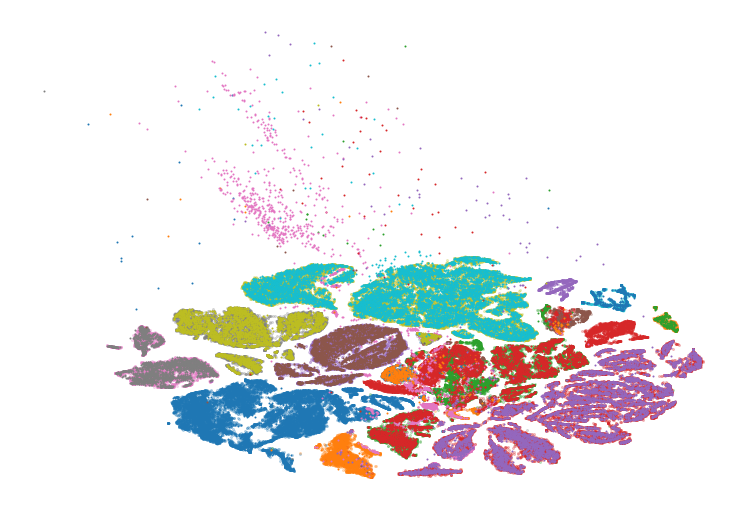

In [24]:
fig = plt.figure(figsize=(13, 9))
utils.plot(embedding_train, y_train, ax=fig.gca(), alpha=0.25, ms=2, draw_legend=False)
plt.gca().set_prop_cycle(None)
utils.plot(embedding_test, y_test, ax=fig.gca(), alpha=1, draw_legend=False)